In [2]:
######################
## Imports
######################


import os
import numpy as np
from copy import copy
from sklearn.model_selection import train_test_split
from google.colab import drive
import random

%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc as smp
from tensorflow.python import debug as tf_debug
import datetime
import pandas as pd
import collections
import seaborn as sns
from scipy import stats
from PIL import Image, ImageOps

matplotlib.rcParams.update({'font.size': 22})

TensorFlow 1.x selected.


In [48]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

project_folder = "/content/drive/MyDrive/Number_Estimation/numerosity-estimation-master-data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
def show_an_example_image_for_each_numerosity(df_sel, df_imgs_big):
  fig, ax = plt.subplots(1, 10, figsize=(30,15))
  for i in range(1,11):
    condition = df_sel["num"] == i
    num_indices = df_sel.index[condition]
    num_indices_list = num_indices. tolist()
    img = df_imgs_big[num_indices_list[0]].reshape(28,28)
    ax[i-1].imshow(img, cmap=plt.cm.gray)
    ax[i-1].set_title('Image')

  plt.tight_layout()
  plt.show()



def plot_area_distr(df_sel, plot_type='curve'):
  if(plot_type=='curve'):
    fig = plt.figure(figsize=(20, 12))
    for k in range(2,11,1):
        b = sns.distplot(df_sel[df_sel.num==k]['area'], label=str(k), hist = False, kde = True, rug=True)  
        plt.legend(prop={'size': 12})
        b.set_xlabel("total area",fontsize=20)
  elif(plot_type=='boxplot'):
     b = sns.boxplot(x=df_sel['num'], y=df_sel['area']) 
  
  elif(plot_type=='stackedbars'):
    max_area=250
    area_range = range(max_area)
    accum_area_counts = np.array([0]*max_area)
    for k in range(1,11,1):
      count_for_each_area=[df_sel[(df_sel.num==k) & (df_sel.area==a)]['index'].count() for a in area_range]
      plt.bar(area_range, count_for_each_area,bottom = accum_area_counts)
      accum_area_counts += np.array(count_for_each_area)
      

    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()




def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.03, .9), xycoords=ax.transAxes)

In [10]:
## Probability for given total area A, that this stems from N objects

def p_N_given_A_for_all_A(N, accum_area_counts, df_sel):
    max_area=250
    area_range = range(max_area)
    num_count_for_each_area=np.array( [df_sel[(df_sel.num==N) & (df_sel.area==a)]['index'].count() for a in area_range] , dtype=float)
    total_num_for_each_area = np.array(accum_area_counts, dtype=float)
    p_n_a = np.divide(num_count_for_each_area, total_num_for_each_area, out=np.zeros_like(num_count_for_each_area), where=total_num_for_each_area!=0) #num_count_for_each_area/total_num_for_each_area]
    
    return p_n_a

def mean_weighted_p_N_A(N, accum_area_counts, df_sel):
    max_area=250
    area_range = range(max_area)
    n_of_N_objects_for_each_A = np.array( [df_sel[(df_sel.num==N) & (df_sel.area==a)]['index'].count() for a in area_range])
    total_n_of_N_objects = df_sel[df_sel.num==N]['index'].count()
    p_N_given_A_for_all_A_output = p_N_given_A_for_all_A(N, accum_area_counts, df_sel)

    weighted_p_N_given_A_for_all_A = p_N_given_A_for_all_A_output * n_of_N_objects_for_each_A / total_n_of_N_objects
    weighted_mean = np.sum(weighted_p_N_given_A_for_all_A)

    return weighted_mean

def get_base_line_acc(df_sel):
    base_line_acc = []

    max_area = 250
    area_range = range(max_area)
    accum_area_counts = np.array([0]*max_area)    
    for k in range(1,11,1):
      count_for_each_area=[df_sel[(df_sel.num==k) & (df_sel.area==a)]['index'].count() for a in area_range]
      accum_area_counts += np.array(count_for_each_area)
  
    for n in range(1,11,1):
      
      mean_weighted_p_N_A_of_n = mean_weighted_p_N_A(n, accum_area_counts, df_sel)
      base_line_acc.append(mean_weighted_p_N_A_of_n)
      print('N: ', mean_weighted_p_N_A_of_n)




N:  0.6779458677366342
N:  0.3442458515312723
N:  0.2509945147957887
N:  0.2023580505934483
N:  0.18539136470451462
N:  0.16820164606229826
N:  0.17736644917290012
N:  0.18855742520628765
N:  0.22748625678655668
N:  0.3501536322708774


In [ ]:
fig = plt.figure(figsize=(20, 12))
for k in range(2,11,1):
    b = sns.distplot(df_sel[df_sel.num==k]['hull'], label=str(k), hist = False, kde = True, rug=True)  
    plt.legend(prop={'size': 12})
    b.set_xlabel("convex hull",fontsize=20)

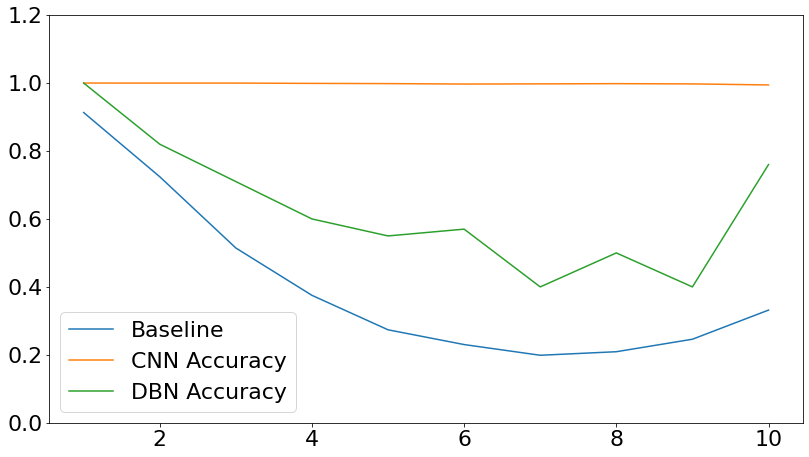

In [ ]:
cnn_acc = np.array([1.0, 0.99990064, 0.9999, 0.99901175, 0.9983807, 0.9970417, 0.9975935, 0.9982116, 0.9974892, 0.99445283])
dbn_acc = np.array([1.0, 0.82, 0.71, 0.6, 0.55, 0.57, 0.4, 0.5, 0.4, 0.76])
base_line_acc = np.array(base_line_acc)

plt.ylim(0.0, 1.2)
plt.plot(range(1,11,1), base_line_acc, label='Baseline')
plt.plot(range(1,11,1), cnn_acc, label='CNN Accuracy')
plt.plot(range(1,11,1), dbn_acc, label='DBN Accuracy')
plt.legend()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(13.5, 7.5)


In [50]:
#############
## Load Default Data-set: Random-Uniform sizedsquares
#######################################

# Load 60.000 used for train/test. 
df_big = pd.read_csv(project_folder +  'data/train_test/data_train_test.csv')
df_imgs_big = np.load(project_folder + 'data/train_test/imgs_train_test.npy')
df_big_labels = df_big.num.values

In [60]:
#############
## Load Equal-Square-Size Dataset
#######################################

# Load 60.000 used for train/test. 
df_big = pd.read_csv(project_folder +  'data/equal_square_size/data_equal_square_size_60000.csv')
df_imgs_big = np.load(project_folder + 'data/equal_square_size/data_equal_square_size_60000.npy')
df_big_labels = df_big.num.values

In [67]:
#############
## Load RECTANGLE Dataset
#######################################

# Load 60.000 used for train/test. 
df_big = pd.read_csv(project_folder +  'data/rectangle/data_rectangle_60000.csv')
df_imgs_big = np.load(project_folder + 'data/rectangle/data_rectangle_60000.npy')
df_big_labels = df_big.num.values

In [74]:
#############
## Load RECTANGLE / FIXED TOTAL AREA Dataset
#######################################

# Load 60.000 used for train/test. 
df_big = pd.read_csv(project_folder +  'data/rectangle/data_rectangle_fixed_total_area_60000.csv')
df_imgs_big = np.load(project_folder + 'data/rectangle/data_rectangle_fixed_total_area_60000.npy')
df_big_labels = df_big.num.values

In [75]:
df_sel=df_big

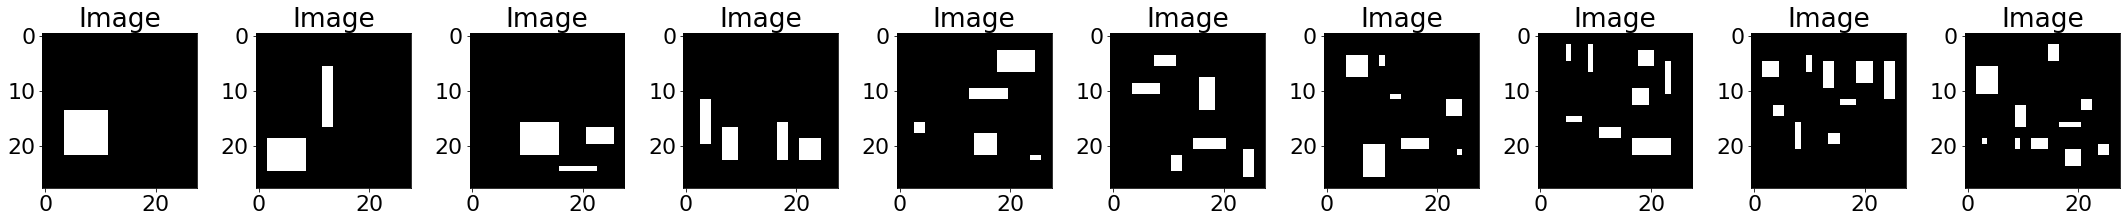

In [76]:
show_an_example_image_for_each_numerosity(df_sel, df_imgs_big)

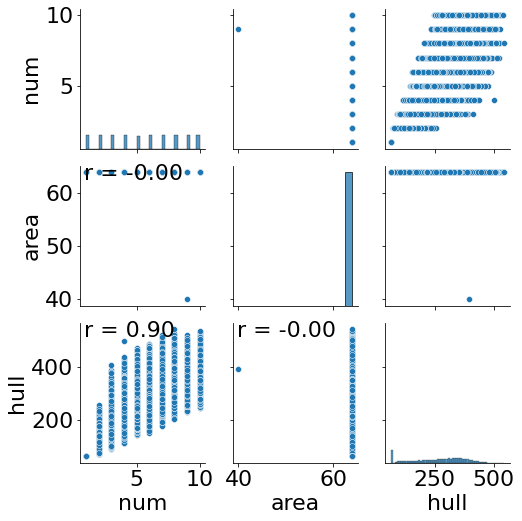

In [77]:
# Num-Area-Hull-Correlation
g = sns.pairplot(df_sel[['num','area','hull']])
g.map_lower(corrfunc)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

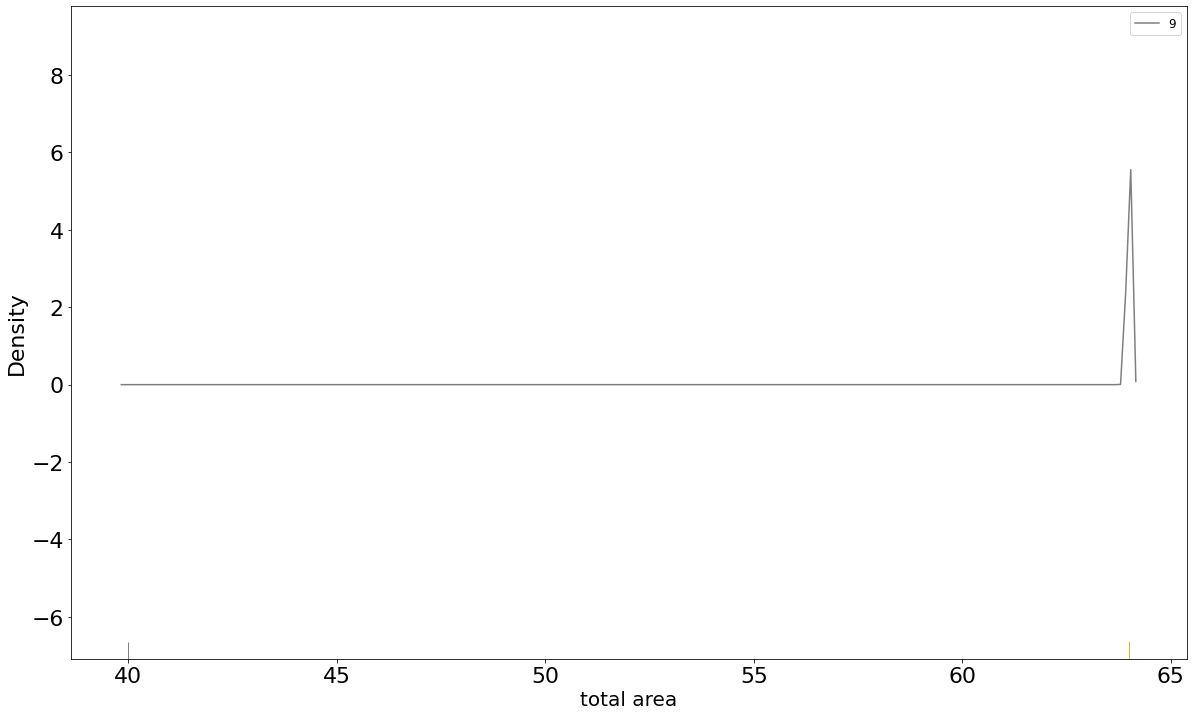

In [78]:
plot_area_distr(df_sel, plot_type='curve')

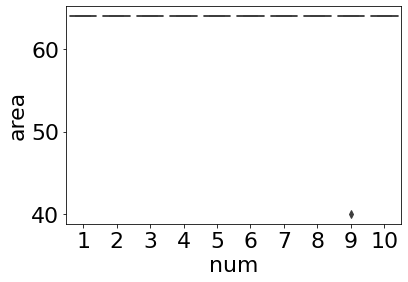

In [79]:
plot_area_distr(df_sel, plot_type='boxplot')

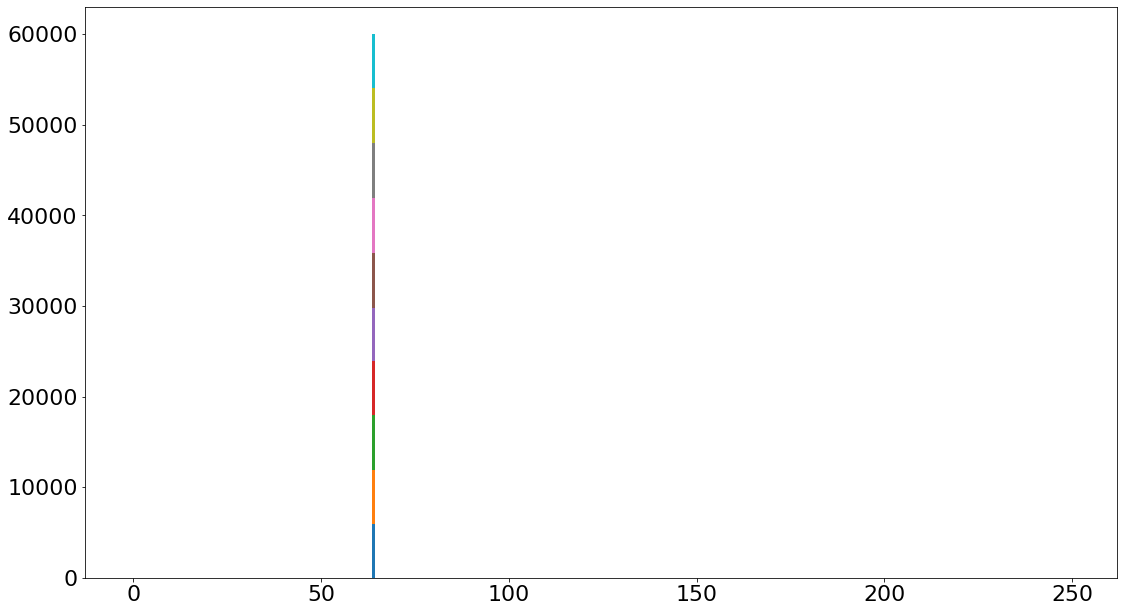

In [80]:
plot_area_distr(df_sel, plot_type='stackedbars')

In [59]:
get_base_line_acc(df_sel)

N:  0.9196951140791114
N:  0.7219561239712732
N:  0.5113242858367038
N:  0.3674938516283828
N:  0.2787103736654268
N:  0.2260847641256234
N:  0.20228304838705763
N:  0.20727836032766378
N:  0.24787175618874485
N:  0.3443418461434316
